In [5]:
import pandas as pd
import numpy as np
import cvxpy as cp # for optimization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_synth_control_data(n_units=5, n_periods=10, treat_unit=0, treat_time=6, random_seed=42):
    """
    n_units: number of units (e.g., states)
    n_periods: time periods (e.g., years)
    treat_unit: index of the treated unit
    treat_time: period at which treatment starts (1-indexed)
    """
    np.random.seed(random_seed)
    data = []
    
    for unit in range(n_units):
        # Random baseline and trend
        baseline = np.random.normal(50, 5)
        trend = np.random.uniform(0.8, 1.2)  # slope
        effect = 5 if unit == treat_unit else 0  # effect for the treated unit
        
        for t in range(1, n_periods+1):
            outcome = baseline + trend * t
            # Add post-treatment effect if this is the treated unit and period >= treat_time
            if unit == treat_unit and t >= treat_time:
                outcome += effect
            
            # Additional noise
            outcome += np.random.normal(0, 2)
            
            data.append({
                'unit': f'State_{unit}',
                'time': t,
                'outcome': outcome
            })
    
    df_synth = pd.DataFrame(data)
    return df_synth

# Example usage:
df_synth = generate_synth_control_data()
df_synth.head()

,unit,time,outcome
0,State_0,1,53.299840
1,State_0,2,52.445406
2,State_0,3,56.399768
3,State_0,4,57.412844
4,State_0,5,59.968589


In [3]:
df_synth.describe()

,time,outcome
count,50.000000,50.000000
mean,5.500000,55.468960
std,2.901442,5.464733
min,1.000000,44.696566
25%,3.000000,51.762706
50%,5.500000,55.276461
75%,8.000000,59.658006
max,10.000000,65.470583


<Axes: xlabel='time'>

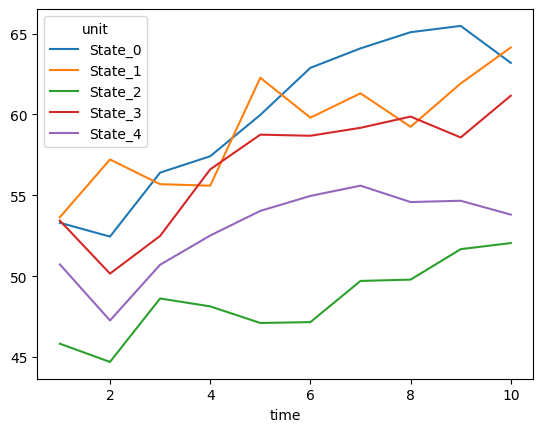

In [4]:
# plot outcome over time
df_synth.pivot(index='time', columns='unit', values='outcome').plot()

In [6]:
# Define treated unit and treatment time
treated_unit = 'State_3'      # Replace with your treated unit identifier
treatment_time = 6   # Replace with your treatment time period

In [7]:
# Identify control units
control_units = df_synth['unit'].unique().tolist()
control_units.remove(treated_unit)

print("Control Units:", control_units)

Control Units: ['State_0', 'State_1', 'State_2', 'State_4']


In [9]:
# Constructing the Synthetic Control
# Pivot the data
pivot_df = df_synth.pivot(index='time', columns='unit', values='outcome')

# Display the pivoted data
print(pivot_df.head())

unit    State_0    State_1    State_2    State_3    State_4
time                                                       
1     53.299840  53.642678  45.822449  53.429481  50.723424
2     52.445406  57.213326  44.696566  50.157422  47.260449
3     56.399768  55.685275  48.617974  52.485399  50.702785
4     57.412844  55.593208  48.131183  56.600503  52.510547
5     59.968589  62.265604  47.104016  58.748722  54.034172


In [10]:
# Define pre-treatment and post-treatment periods
pre_treatment = pivot_df[pivot_df.index < treatment_time]
post_treatment = pivot_df[pivot_df.index >= treatment_time]

# Extract treated unit's pre-treatment outcomes
treated_pre = pre_treatment[treated_unit].values

# Extract control units' pre-treatment outcomes
control_pre = pre_treatment[control_units].values

In [11]:
# Define optimization strategy
# We aim to find weights w for control units such that the weighted average of control units’ pre-treatment outcomes 
# closely matches the treated unit’s pre-treatment outcomes.

# Number of control units
n_controls = len(control_units)

# Define weights as a convex combination
w = cp.Variable(n_controls)

# Define the objective: minimize the squared difference
objective = cp.Minimize(cp.sum_squares(control_pre @ w - treated_pre))

# Define the constraints
constraints = [w >= 0, cp.sum(w) == 1]

# Define and solve the problem
prob = cp.Problem(objective, constraints)
prob.solve()

# Retrieve the optimal weights
weights = w.value

# Display the weights
weights_df = pd.DataFrame({'Control Unit': control_units, 'Weight': weights})
print(weights_df)

  Control Unit        Weight
0      State_0  6.379502e-01
1      State_1  1.899608e-03
2      State_2 -9.215753e-19
3      State_4  3.601502e-01


In [12]:
# Create synthetic control pre-treatment
synthetic_pre = control_pre @ weights

# Display comparison
comparison = pd.DataFrame({
    'Time': pre_treatment.index,
    'Treated': treated_pre,
    'Synthetic Control': synthetic_pre
})

print(comparison.head())

   Time    Treated  Synthetic Control
0     1  53.429481          52.372595
1     2  50.157422          50.587100
2     3  52.485399          54.346641
3     4  56.600503          55.643824
4     5  58.748722          57.835671


<Axes: xlabel='Time'>

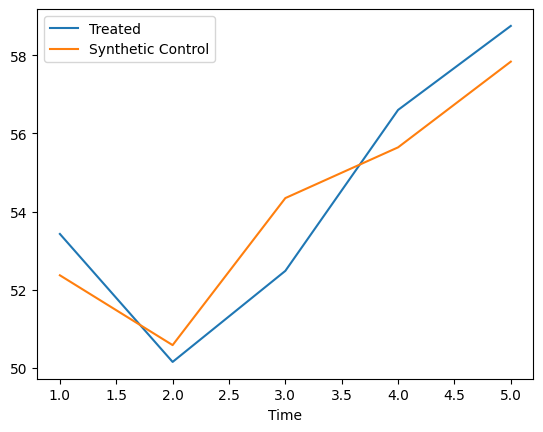

In [13]:
# plot comparison
comparison.plot(x='Time')

In [14]:
# Estimating the Treatment Effect
# Extract control units' outcomes for all periods
control_all = pivot_df[control_units].values

# Construct synthetic control for all periods
synthetic_all = control_all @ weights

# Add synthetic control to the DataFrame
pivot_df['Synthetic Control'] = synthetic_all

# Extract treated unit's outcomes
pivot_df['Treated'] = pivot_df[treated_unit]

In [15]:
pivot_df.head()

unit,State_0,State_1,State_2,State_3,State_4,Synthetic Control,Treated
time,,,,,,,
1,53.299840,53.642678,45.822449,53.429481,50.723424,52.372595,53.429481
2,52.445406,57.213326,44.696566,50.157422,47.260449,50.587100,50.157422
3,56.399768,55.685275,48.617974,52.485399,50.702785,54.346641,52.485399
4,57.412844,55.593208,48.131183,56.600503,52.510547,55.643824,56.600503
5,59.968589,62.265604,47.104016,58.748722,54.034172,57.835671,58.748722


In [16]:
# Calculate the treatment effect
pivot_df['Treatment Effect'] = pivot_df['Treated'] - pivot_df['Synthetic Control']

# Display the treatment effect
print(pivot_df[['Treated', 'Synthetic Control', 'Treatment Effect']].head(15))

unit    Treated  Synthetic Control  Treatment Effect
time                                                
1     53.429481          52.372595          1.056886
2     50.157422          50.587100         -0.429678
3     52.485399          54.346641         -1.861242
4     56.600503          55.643824          0.956679
5     58.748722          57.835671          0.913051
6     58.679535          60.020762         -1.341228
7     59.170510          61.020075         -1.849565
8     59.864608          61.289882         -1.425274
9     58.574781          61.570827         -2.996046
10    61.157145          59.809252          1.347893


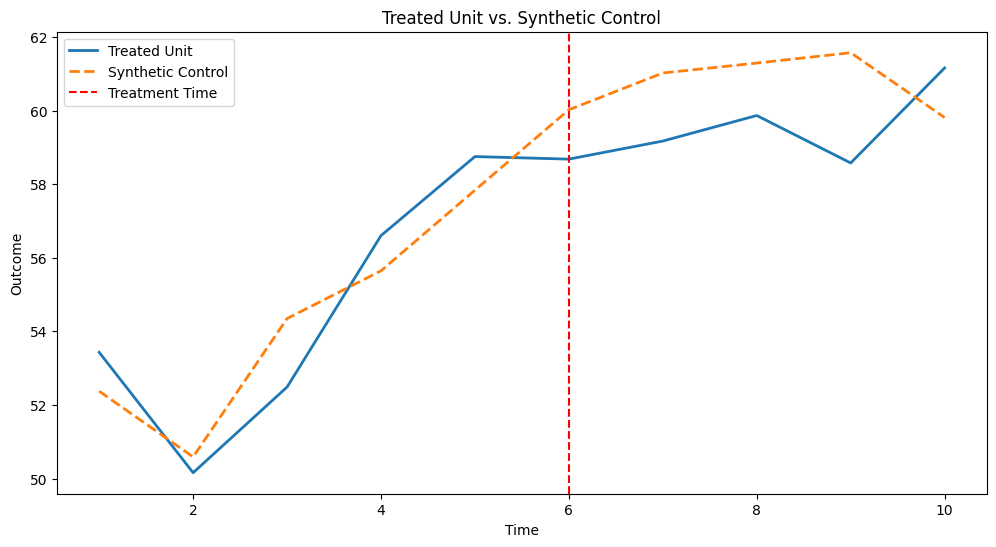

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(pivot_df.index, pivot_df['Treated'], label='Treated Unit', linewidth=2)
plt.plot(pivot_df.index, pivot_df['Synthetic Control'], label='Synthetic Control', linewidth=2, linestyle='--')
plt.axvline(x=treatment_time, color='red', linestyle='--', label='Treatment Time')
plt.xlabel('Time')
plt.ylabel('Outcome')
plt.title('Treated Unit vs. Synthetic Control')
plt.legend()
plt.show()

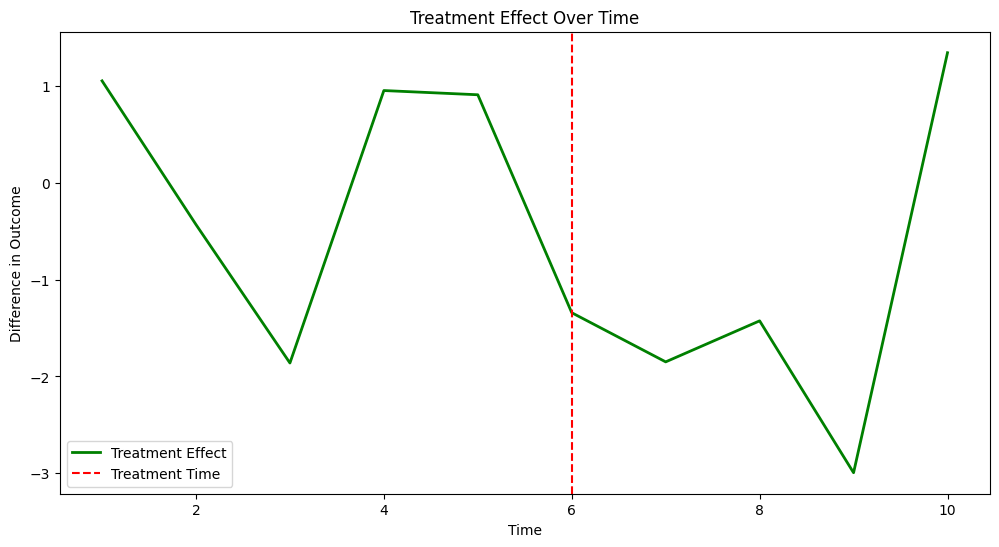

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(pivot_df.index, pivot_df['Treatment Effect'], label='Treatment Effect', color='green', linewidth=2)
plt.axvline(x=treatment_time, color='red', linestyle='--', label='Treatment Time')
plt.xlabel('Time')
plt.ylabel('Difference in Outcome')
plt.title('Treatment Effect Over Time')
plt.legend()
plt.show()

In [19]:
df_synth.head()

,unit,time,outcome
0,State_0,1,53.299840
1,State_0,2,52.445406
2,State_0,3,56.399768
3,State_0,4,57.412844
4,State_0,5,59.968589


In [24]:
from pysyntheticcontrol import Synth
import matplotlib.pyplot as plt

# Initialize the Synth object
synth = Synth()

# Fit the model
synth.fit(
    df=pivot_df,
    treated_unit=treated_unit,
    time_var=pivot_df.index.name,
    unit_var='unit',
    outcome_var='outcome',
    predictors=control_units,  # Define appropriate predictors
    treatment_time=treatment_time
)

# Get the synthetic control
synthetic = synth.synthetic_control

# Plot the results
synth.plot()

# Get treatment effect
treatment_effect = synth.treatment_effect
print("Treatment Effect:", treatment_effect)

Dataprep
Treated unit: State_3
Dependent variable: outcome
Control units: State_0, State_1, State_2, State_4
Time range in data: 1 - 10
Time range for loss minimization: range(1, 10)
Time range for predictors: range(1, 5)
Predictors: 



In [25]:
synth = Synth()
synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="equal")

synth.weights()

ZeroDivisionError: division by zero

In [ ]:
# https://github.com/sdfordham/pysyncon/blob/main/examples/basque.ipynb